In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from PIL import Image

In [3]:
stepdata=1 # sparsify data before computing
k=21 # choose number of clusters
maxiterations=1000 # number of iterations
whichalgo=1 # which algorithm
whichimage=0 # which image to start with
doubleprecision=0 # if double precision or not

In [4]:
# also control "step" that sets how much of final plot to show (too many points takes too long even if kmeans if fast)
if whichimage==0:
    logo = Image.open("h2o-logo.jpg");step=13
if whichimage==1: 
    logo = Image.open("low_h2o-logo.jpg");step=2
if whichimage==2:
    logo = Image.open("lowlow_h2o-logo.jpg");step=1

In [5]:
data = array(logo)

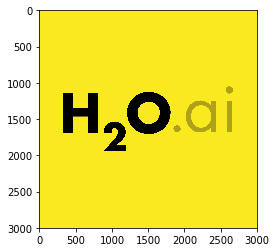

In [6]:
imshow(data)

In [7]:
data.shape

(3000, 3000, 3)

In [8]:
N = int(data.shape[0]*data.shape[1]/2)
seed(777)
space = concatenate((randint(0, data.shape[0], N)[:, newaxis], randint(0, data.shape[1], N)[:, newaxis]), axis=1)

In [9]:
uspace = zeros_like(data)
uspace[space[:, 0], space[:, 1]] = 1

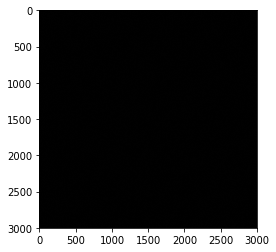

In [10]:
imshow(uspace)

In [11]:
dots = data * uspace

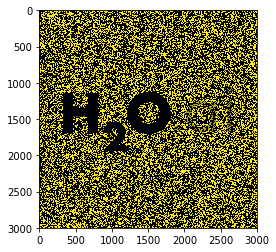

In [12]:
imshow(dots)

In [13]:
dataset = vstack(nonzero(dots)).T

In [14]:
#numpy.set_printoptions(threshold=numpy.nan)
#print(dataset)

In [15]:
dataset = dataset[::stepdata]    
np.isfortran(dataset)
print(type (dataset))
print(dataset.shape)

rows=np.shape(dataset)[0]
print("rows=%d" % (rows))
labels = np.random.randint(rows, size=rows) % k

if doubleprecision==1:
    dataset = dataset.astype(float64)
    labels = labels.astype(float32)
else:
    dataset = dataset.astype(float32)
    labels = labels.astype(float32)

for i in range(k):
    print(i in labels)

<class 'numpy.ndarray'>
(10116514, 3)
rows=10116514
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
print(labels)
print(dataset)

[  2.   2.  10. ...,   0.   8.  11.]
[[  0.00000000e+00   4.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   4.00000000e+00   2.00000000e+00]
 ..., 
 [  2.99900000e+03   2.99900000e+03   0.00000000e+00]
 [  2.99900000e+03   2.99900000e+03   1.00000000e+00]
 [  2.99900000e+03   2.99900000e+03   2.00000000e+00]]


In [17]:
if whichalgo==0:
    import libKMCUDA
    %time cents, asses = libKMCUDA.kmeans_cuda(dataset, k, seed=77, device=0, yinyang_t=0,tolerance=1e-3,verbosity=1)
    # 3m25s on 1 titanX pascal with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=0 , whichimage=0
if whichalgo==1:
    import h2ogpuml
    rows=np.shape(dataset)[0]
    np.random.seed(1234)
    n_gpus=1
    init_from_labels=0 # so auto-generate initial centroids, no need to initialize labels or centroids
    model = h2ogpuml.KMeansGPU(n_gpus=n_gpus, k=k, threshold=1e-7, max_iterations=maxiterations,init_from_labels=init_from_labels)
    %time cents,timefit0,timefit1=model.fit(dataset, labels)
    asses = model.predict(dataset)
    # 14s on 1 titanX pascal with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=1 , whichimage=0
    # 26s on 1 titanX maxwell with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=1 , whichimage=0
    # 4s on 4 titanX pascals with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=1 , whichimage=0

if whichalgo==2:
    #hist(dataset)
    np.savetxt("data.csv",dataset,delimiter=",")
    # see /opt/intel/compilers_and_libraries_2017/linux/daal/examples/python/source/kmeans
    # source /opt/intel/compilers_and_libraries_2017/linux/daal/bin/daalvars.sh intel64
    # cp -a /opt/intel/compilers_and_libraries_2017/linux/daal/examples/python/source/utils  ~/.pyenv/versions/3.6.1/lib/python3.6/site-packages/
    # sudo chown -R $USER:$USER /opt/intel
    # cd /opt/intel/compilers_and_libraries_2017/linux/daal/pydaal_sources ; python setup.py install
    
    # 59s with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=2 , whichimage=0 physics.umd.edu
    # 50s with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=2 , whichimage=0 pseudotensor
    from daal.data_management import (
        FileDataSource, DataSourceIface
    )
    from daal.algorithms.kmeans import (
        Batch_Float32LloydDense, init, data, inputCentroids, assignments, centroids, goalFunction
    )
    from os.path import join as jp
    datasetFileName = jp('data.csv')
    
    import inspect, sys, os.path
    utils_folder = os.path.realpath(os.path.abspath(jp(os.path.split(inspect.getfile(inspect.currentframe()))[0], "..")))
    if utils_folder not in sys.path:
        sys.path.insert(0, utils_folder)
    from utils import printNumericTable
    from utils import isFull
        
    from daal.data_management import (
        CSRNumericTable, NumericTableIface, readOnly, BlockDescriptor,
        packed_mask, HomogenNumericTable, KeyValueDataCollection,
        DataSourceIface, FileDataSource, HomogenTensor, SubtensorDescriptor,
    )

    # K-Means algorithm parameters
    nClusters = k
    nIterations = maxiterations

    # Initialize FileDataSource to retrieve the input data from a .csv file
    dataSource = FileDataSource(
        datasetFileName,
        DataSourceIface.doAllocateNumericTable,
        DataSourceIface.doDictionaryFromContext
    )

    # Retrieve the data from the input file
    dataSource.loadDataBlock()

    # Get initial clusters for the K-Means algorithm (can change Float32 to Float64)
    initAlg = init.Batch_Float32RandomDense(nClusters)

    initAlg.input.set(init.data, dataSource.getNumericTable())

    res = initAlg.compute()
    %time centroidsResult = res.get(init.centroids)

    # Create an algorithm object for the K-Means algorithm (can change Float32 to Float64)
    algorithm = Batch_Float32LloydDense(nClusters, nIterations)

    algorithm.input.set(data, dataSource.getNumericTable())
    algorithm.input.set(inputCentroids, centroidsResult)

    %time res = algorithm.compute()

    # Print the clusterization results
    asses0 = res.get(assignments)
    cents0 = res.get(centroids)

    num_rows = asses0.getNumberOfRows()
    num_cols = asses0.getNumberOfColumns()
    layout = asses0.getDataLayout()
    if isFull(layout) or layout == NumericTableIface.csrArray:
        datatype=0
    else:
        datatype=1
    print("asses: num_rows=%d num_cols=%d datatype=%d" % (num_rows,num_cols,datatype))
    block = BlockDescriptor()
    asses0.getBlockOfRows(0, num_rows, readOnly, block)
    asses=block.getArray()
    
    num_rows = cents0.getNumberOfRows()
    num_cols = cents0.getNumberOfColumns()
    layout = cents0.getDataLayout()
    if isFull(layout) or layout == NumericTableIface.csrArray:
        datatype=0
    else:
        datatype=1
    print("cents: num_rows=%d num_cols=%d datatype=%d" % (num_rows,num_cols,datatype))
    block2 = BlockDescriptor()
    cents0.getBlockOfRows(0, num_rows, readOnly, block2)
    cents=block2.getArray()
    
    printNumericTable(res.get(assignments), "First k cluster assignments:", k)
    printNumericTable(res.get(centroids), "First 3 dimensions of centroids:", k, 3)
    printNumericTable(res.get(goalFunction), "Goal function value:")
    


Loaded H2OGPUML CPU library

Loaded H2OGPUML GPU library.
Detected np.float32 data
CPU times: user 608 ms, sys: 696 ms, total: 1.3 s
Wall time: 1.33 s


In [18]:
print(type (dataset))

<class 'numpy.ndarray'>


In [19]:
print(cents)

[[  2.69479517e+03   2.07778931e+03   9.99998152e-01]
 [  3.38393463e+02   1.34234265e+03   9.99990344e-01]
 [  9.07499512e+02   1.12394666e+03   9.99923766e-01]
 [  2.35076147e+03   5.82692810e+02   1.00003147e+00]
 [  2.29096875e+03   1.79823389e+03   9.99980032e-01]
 [  5.78491943e+02   1.87929358e+03   9.99991298e-01]
 [  1.61364709e+03   5.99313538e+02   1.00051749e+00]
 [  1.16834619e+03   2.71667627e+03   1.00001442e+00]
 [  3.72264130e+02   4.34666656e+02   1.00000119e+00]
 [  2.12449634e+03   2.39015552e+03   1.00001776e+00]
 [  1.18820142e+03   1.02509216e+03   1.00040221e+00]
 [  1.06468481e+03   5.36661682e+02   1.00041127e+00]
 [  2.50980640e+03   2.45578796e+02   9.99987543e-01]
 [  1.81232446e+03   2.75653931e+03   9.99997675e-01]
 [  4.46627441e+02   2.60819922e+03   9.99996424e-01]
 [  2.53818970e+03   1.08578931e+03   1.00018549e+00]
 [  1.13945508e+03   2.07390356e+03   9.99974191e-01]
 [  2.65948877e+03   2.72669336e+03   9.99997973e-01]
 [  1.76840063e+03   1.70632

In [20]:
print(asses)

[ 8  8  8 ..., 17 17 17]


In [21]:
np.ndarray.flatten(asses)

array([ 8,  8,  8, ..., 17, 17, 17], dtype=int32)

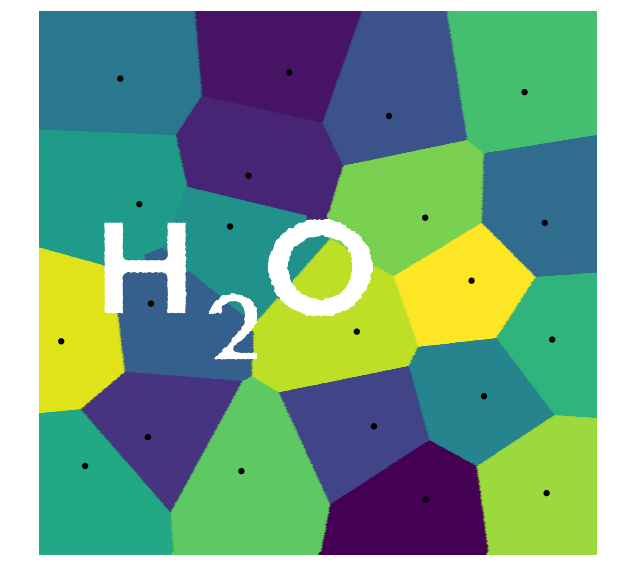

In [22]:
rcParams["figure.figsize"] = (10, 10)
scatter(dataset[::step, 1], dots.shape[0] - dataset[::step, 0], c=asses[::step], edgecolors="none")
scatter(cents[:, 1], dots.shape[0] - cents[:, 0], c="black", s=40, edgecolors="none")
xlim((0, dots.shape[1]))
ylim((0, dots.shape[0]))
axis("off")
savefig("sourced.png", transparent=True, bbox_inches=0, pad_inches=0)